<a href="https://colab.research.google.com/github/folly-l/Stat_463/blob/main/Project9_Applied_Stats_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [2]:
#Calculating the traditional MPT for....
#yf.download(tickers)
#curr_data = yf.download(tickers, start=start, end=end)
tickers = ["SPXL", "SPXS","MMM","ABT", "SPY", "^VIX"]
actual_tickers = ["SPY","JPM", "BAC", "C", "MSFT", "AAPL", "IBM", "GE", "BA", "XOM", "AMZN", "MCD"]
start = "2000-01-01"
end = "2015-12-31"
data = yf.download(tickers, start=start, end=end, auto_adjust=False)

full_data = yf.download(actual_tickers, start=start, end=end, auto_adjust=False)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  12 of 12 completed


Adjusted Close accounts for splits, dividends, and corporate actions, so  returns are realistic.

In [3]:
adj_close = full_data["Adj Close"]


In [5]:
PRE_crisis = adj_close.loc["2000-01-01":"2007-12-31"]
transition_crisis = adj_close.loc["2008-01-01":"2008-12-31"]
POST_crisis = adj_close.loc["2009-01-01":"2015-12-31"]

In [4]:
prices = data["Adj Close"]


In [6]:
pre_crisis = prices.loc["2000-01-01":"2007-12-31"]
transition = prices.loc["2008-01-01":"2008-12-31"]
post_crisis = prices.loc["2009-01-01":"2015-12-31"]


In [7]:
def portfolio_performance(weights, mu, cov):
    ret = np.dot(weights, mu)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return ret, vol

In [8]:
def negative_sharpe(weights, mu, cov):
    ret, vol = portfolio_performance(weights, mu, cov)
    return -ret / vol

The first question: How do machine learning models perform in stable vs. crisis-driven markets?

# How do machine learning models perform in stable vs. crisis-driven markets?

## MPT

MPT - Modern Portfolio Optimization

### Using only SPY

Why only SPY?
 - In 2000-2008, SPXS and SPXL were not calculated.

In [9]:
assets_pre = pre_crisis[["SPY"]].dropna()
returns_pre = assets_pre.pct_change().dropna()

In [10]:
mu = returns_pre.mean() * 252   # annualized
# 252 ≈ trading days per year
#mu
cov = returns_pre.cov() * 252   # annualized
#cov
vol_daily = returns_pre.std()
#vol_daily
vol_annual = vol_daily * np.sqrt(252)
#vol_annual
n_assets = len(mu)
#n_assets

In [11]:
#The SLSQP algorithm described by Dieter Kraft is a quasi-Newton method (using BFGS)
#applied to a Lagrange function consisting of loss function
#and equality- and inequality constraints.
constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1}
)

bounds = tuple((0, 1) for _ in range(n_assets))
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    negative_sharpe,
    initial_weights,
    args=(mu, cov),
    #(Sequential Least SQuares Programming)
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

optimal_weights_pre = result.x

In [12]:
ret_pre, vol_pre = portfolio_performance(optimal_weights_pre, mu, cov)
sharpe_pre = ret_pre / vol_pre

ret_pre, vol_pre, sharpe_pre

(np.float64(0.03304293714403886),
 np.float64(0.18069013722590382),
 np.float64(0.18287072914626026))

The expected return was 0.033 → 3.3% annualized
- Meaning: if an investor followed MPT potfolio in 2000-2007, they would expected ~3.3% return per year. This seems low because we are only using SPY which is just one asset, a diversified portolio would yield  higher Sharpe-Adjusted returns.

The Expected Volatility was 0.1807 → 18.1% annualized volatility
- Meaning: SPY experienced ~ 18% standard deviation of annual returns in that period, which was a moderate risk for a "stable" pre-crisis market.
- It matches the historical observation of a calmer time pre-2008.

The Sharpe Ratio was 0.1829 → a very low Sharpe ratio
- Meaning: Sharpe = return/ risk, where we are assuming it is risk free so ≈ 0. 0.18 being a low risk-adjusted return means for the risk taken, the reward is modest. This is not surpising as this portfolio is not diversified so there's no leverage to diversify risk.

NOTE: Sharpe Ratio is annualized since our return and volatitlity were annualized too.

**Note:** *Using synthesized SPXS and SPXl, we tried to synthesize SPXS and SPXL using SPY but the results were very unrealistic giving almost -100% and 100% for Expected Volatility and Sharpe Ratio respectively.*

### Using a more diversified portfolio (SPY, MMM, ABT)

In [20]:
pre_crisis = prices.loc["2000-01-01":"2007-12-31"].copy()
post_crisis = prices.loc["2009-01-01":"2015-12-31"].copy()



In [21]:
returns_pre = pre_crisis[["SPY", "MMM", "ABT"]].pct_change().dropna()
mu = returns_pre.mean() * 252
cov = returns_pre.cov() * 252

In [23]:
n_assets = len(mu)
initial_weights = np.ones(n_assets) / n_assets
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

In [24]:
result = minimize(negative_sharpe, initial_weights, args=(mu, cov),
                  method="SLSQP", bounds=bounds, constraints=constraints)

optimal_weights_pre = result.x
ret_pre, vol_pre = portfolio_performance(optimal_weights_pre, mu, cov)
sharpe_pre = ret_pre / vol_pre


In [25]:
print("Optimal weights:", optimal_weights_pre)
print("Expected return:", ret_pre)
print("Expected volatility:", vol_pre)
print("Sharpe ratio:", sharpe_pre)

Optimal weights: [5.89805982e-17 5.45750264e-01 4.54249736e-01]
Expected return: 0.12937399264025495
Expected volatility: 0.20491213069392933
Sharpe ratio: 0.6313632687441855


Expected returns:
- ~13% annual → which sounds reasonable for a pre-crisis period

Sharpe Ratio:
- ~0.63 → a good baseline performance

### Diversified (2009-2015)

In [26]:
returns_post = post_crisis[["SPY", "MMM", "ABT"]].pct_change().dropna()
mu = returns_post.mean() * 252
cov = returns_post.cov() * 252

In [27]:
n_assets = len(mu)
initial_weights = np.ones(n_assets) / n_assets
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

In [28]:
result = minimize(negative_sharpe, initial_weights, args=(mu, cov),
                  method="SLSQP", bounds=bounds, constraints=constraints)

optimal_weights_post = result.x
ret_post, vol_post = portfolio_performance(optimal_weights_post, mu, cov)
sharpe_post = ret_post / vol_post

In [29]:
print("Optimal weights:", optimal_weights_post)
print("Expected return:", ret_post)
print("Expected volatility:", vol_post)
print("Sharpe ratio:", sharpe_post)

Optimal weights: [0.25703229 0.45310573 0.28986198]
Expected return: 0.1586244875202898
Expected volatility: 0.1696028066884798
Sharpe ratio: 0.9352704157287056


Optimal weights:
- [0.26, 0.45, 0.29]

Expected returns:
- ~15% annual → meaning we likely got out of the crisis faster than predicted

Sharpe Ratio:
- ~0.93 → a good baseline performance

## Machine Learning (Supervised)

In our draft, we had mentioned the plan to use SPXL to calculate next-day returns but we decided to use **next day SPY return** as our *target variable* because in 2000-2008, SPXS and SPXL were not calculated. To manintain a balance and avoid unneccessary inaccuracies we settled on SPY. We decided to try out five different models:
- Random Forest
- XGBoost
- LSTM
- Linear Regression
- ARIMA

Due to the unexpected change in 2008, we tried both static modelling and "rolling-window" modelling for some machine learning models listed.

In [30]:
train_pre_crisis = prices.loc["2000-01-01":"2006-12-31"].copy()
test_pre_crisis = prices.loc["2007-01-01":"2007-12-31"].copy()

train_pre_crisis = train_pre_crisis.drop(["SPXL", "SPXS"], axis=1)
test_pre_crisis = test_pre_crisis.drop(["SPXL", "SPXS"], axis=1)
#print(train_pre_crisis.isnull().sum())
#print(test_pre_crisis.isnull().sum())

In [31]:
# SPY daily returns
train_pre_crisis["SPY_return"] = train_pre_crisis["SPY"].pct_change()
test_pre_crisis["SPY_return"] = test_pre_crisis["SPY"].pct_change()

# Next-day return as target
train_pre_crisis["SPY_next_return"] = train_pre_crisis["SPY_return"].shift(-1)
test_pre_crisis["SPY_next_return"] = test_pre_crisis["SPY_return"].shift(-1)

In [32]:
train_pre_crisis["VIX"] = prices["^VIX"].loc[train_pre_crisis.index]
test_pre_crisis["VIX"] = prices["^VIX"].loc[test_pre_crisis.index]

# Rolling 10-day SPY volatility

train_pre_crisis["SPY_vol_10"] = train_pre_crisis["SPY_return"].rolling(10).std()
test_pre_crisis["SPY_vol_10"] = test_pre_crisis["SPY_return"].rolling(10).std()


In [33]:

columns_to_check = ["SPY_return", "SPY_next_return", "SPY_vol_10"]

# Drop rows with NaNs in those columns only
train_pre_crisis = train_pre_crisis.dropna(subset=columns_to_check)
test_pre_crisis = test_pre_crisis.dropna(subset=columns_to_check)

# Verifying
print(train_pre_crisis.isnull().sum())
print(test_pre_crisis.isnull().sum())


Ticker
ABT                0
MMM                0
SPY                0
^VIX               0
SPY_return         0
SPY_next_return    0
VIX                0
SPY_vol_10         0
dtype: int64
Ticker
ABT                0
MMM                0
SPY                0
^VIX               0
SPY_return         0
SPY_next_return    0
VIX                0
SPY_vol_10         0
dtype: int64


In [34]:
# Features and target
features = ["SPY_return", "VIX", "SPY_vol_10"]
X_train = train_pre_crisis[features]
y_train = train_pre_crisis["SPY_next_return"]

X_test = test_pre_crisis[features]
y_test = test_pre_crisis["SPY_next_return"]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1748, 3)
Test shape: (240, 3)


### Linear Regression

#### Static Linear Regression

In [35]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression MSE:", mse_lr)


Linear Regression MSE: 0.00010299220989537184


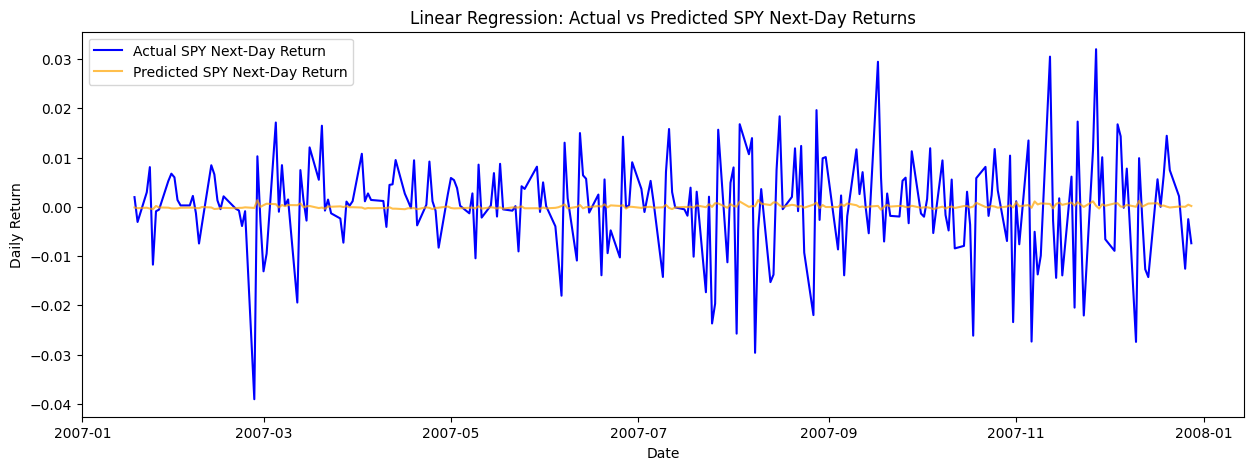

In [36]:
y_pred_lr_series = pd.Series(y_pred_lr, index=y_test.index)

plt.figure(figsize=(15,5))
plt.plot(y_test, label='Actual SPY Next-Day Return', color='blue')
plt.plot(y_pred_lr_series, label='Predicted SPY Next-Day Return', color='orange', alpha=0.7)
plt.title('Linear Regression: Actual vs Predicted SPY Next-Day Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [37]:
val_post_crisis = prices.loc["2009-01-01":"2015-12-31"].copy()
val_post_crisis

Ticker,ABT,MMM,SPXL,SPXS,SPY,^VIX
Date,,,,,,
2009-01-02,17.518661,29.635326,2.580657,578027.375000,68.368324,39.189999
2009-01-05,17.217741,29.289858,2.580657,578678.062500,68.287453,39.080002
2009-01-06,16.655157,29.635326,2.643316,563055.812500,68.743423,38.560001
2009-01-07,16.563570,29.074554,2.421101,612635.125000,66.684166,43.389999
2009-01-08,16.746740,29.329918,2.445648,604172.875000,66.956261,42.560001
...,...,...,...,...,...,...
2015-12-23,37.356873,90.883026,19.464598,7138.549316,175.125839,15.570000
2015-12-24,37.356873,90.901031,19.357555,7177.604492,174.836761,15.740000
2015-12-28,37.298885,90.919098,19.232304,7216.660645,174.437271,16.910000


In [38]:
val_post_crisis = val_post_crisis.drop(["SPXL", "SPXS"], axis=1)
# SPY daily returns
val_post_crisis["SPY_return"] = val_post_crisis["SPY"].pct_change()

# Next-day return (target)
val_post_crisis["SPY_next_return"] = val_post_crisis["SPY_return"].shift(-1)

# VIX aligned
val_post_crisis["VIX"] = prices["^VIX"].loc[val_post_crisis.index]

# Rolling 10-day volatility
val_post_crisis["SPY_vol_10"] = val_post_crisis["SPY_return"].rolling(10).std()

In [39]:
columns_to_check = ["SPY_return", "SPY_next_return", "SPY_vol_10"]

val_post_crisis= val_post_crisis.dropna(subset=columns_to_check)

print(val_post_crisis.isnull().sum())

Ticker
ABT                0
MMM                0
SPY                0
^VIX               0
SPY_return         0
SPY_next_return    0
VIX                0
SPY_vol_10         0
dtype: int64


In [40]:
X_eval = val_post_crisis[features]
y_eval = val_post_crisis["SPY_next_return"]

print("Eval shape:", X_eval.shape)

Eval shape: (1750, 3)


In [41]:
y_pred_eval_lr = lr_model.predict(X_eval)

mse_eval_lr = mean_squared_error(y_eval, y_pred_eval_lr)
print("OOS Linear Regression MSE (2009–2015):", mse_eval_lr)

OOS Linear Regression MSE (2009–2015): 0.00012332949300242866


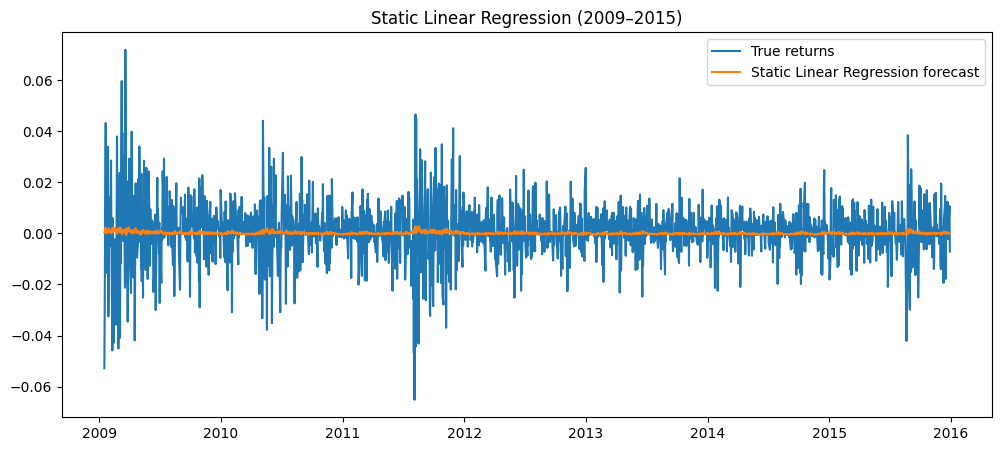

In [42]:
plt.figure(figsize=(12,5))
plt.plot(val_post_crisis.index, y_eval, label="True returns")
plt.plot(val_post_crisis.index, y_pred_eval_lr, label="Static Linear Regression forecast")
plt.legend()
plt.title("Static Linear Regression (2009–2015)")
plt.show()

#### Rolling Linear Regression

since we were not splitting into train, test and evaluate for Rolling, we copied a vesion of our data instead.

In [43]:
#Copy original prices
df = prices.copy()
# Compute SPY daily return
df["SPY_return"] = df["SPY"].pct_change()
# Compute next-day return as target
df["SPY_next_return"] = df["SPY_return"].shift(-1)
# VIX
df["VIX"] = df["^VIX"]
# 10-day rolling SPY volatility
df["SPY_vol_10"] = df["SPY_return"].rolling(10).std()
# Dropping any initial NaNs caused by pct_change or rolling
df = df.dropna(subset=["SPY_return", "SPY_next_return", "SPY_vol_10", "VIX"])

#  features for the regression
features = ["SPY_return", "VIX", "SPY_vol_10"]
rolling_window = 504  # ~2 years (rolling window of 2 years) why? 251 trading
# days in a year
preds = []
y_true = []

# Defining rolling test period
rolling_period = df.loc["2007-01-01":"2015-12-31"]

# Rolling Linear Regression
for i in range(rolling_window, len(rolling_period)-1):
    train_window = rolling_period.iloc[i-rolling_window:i]
    X_train = train_window[features]
    y_train = train_window["SPY_next_return"]

    # using all attributes...
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    X_next = rolling_period[features].iloc[i:i+1]
    y_pred = lr_model.predict(X_next)[0]

    preds.append(y_pred)
    y_true.append(rolling_period["SPY_next_return"].iloc[i])

# Evaluating using Mean Square Error
mse = mean_squared_error(y_true, preds)
print("Rolling Linear Regression MSE:", mse)

Rolling Linear Regression MSE: 0.00012749738729881906


In [44]:
# Dates corresponding to rolling predictions
pred_dates = rolling_period.index[rolling_window:rolling_window + len(preds)]

eval_df = pd.DataFrame(
    {
        "ml_forecast": preds,
        "true_return": y_true,
    },
    index=pred_dates
)



In [45]:
# Trading signal: long if forecast > 0, short if < 0
eval_df["ml_position"] = np.sign(eval_df["ml_forecast"])

# ML strategy returns
eval_df["ml_strategy_return"] = (
    eval_df["ml_position"] * eval_df["true_return"]
)


In [46]:
eval_df["mpt_return"] = eval_df["true_return"]
eval_df["ml_cum"] = (1 + eval_df["ml_strategy_return"]).cumprod()
eval_df["mpt_cum"] = (1 + eval_df["mpt_return"]).cumprod()

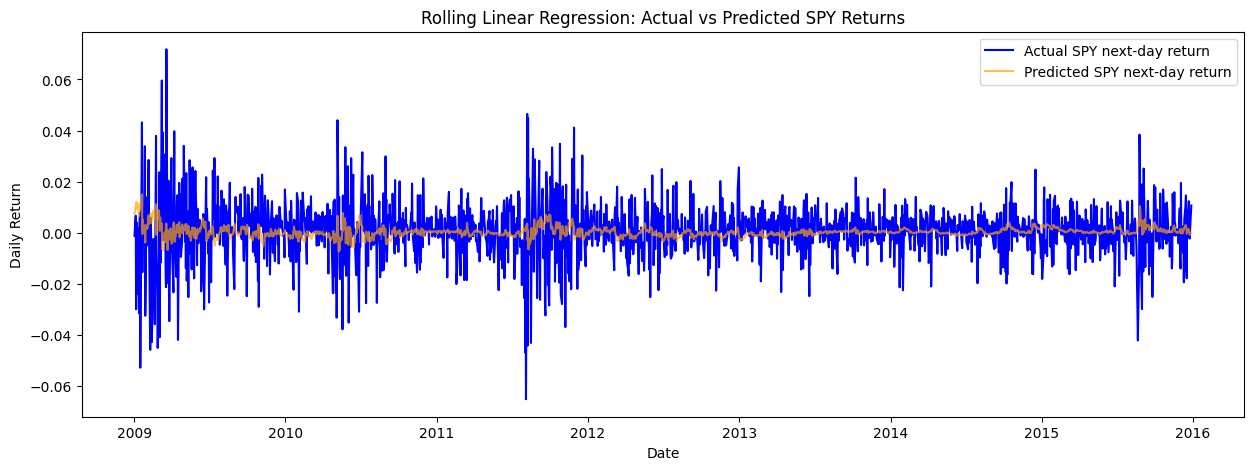

In [47]:
# Convert preds and y_true to a DataFrame with a proper datetime index
rolling_index = df.loc["2007-01-01":"2015-12-31"].index[rolling_window:-1]
results = pd.DataFrame({
    "y_true": y_true,
    "y_pred": preds
}, index=rolling_index)

# Plot actual vs predicted returns
plt.figure(figsize=(15,5))
plt.plot(results.index, results["y_true"], label="Actual SPY next-day return", color='blue')
plt.plot(results.index, results["y_pred"], label="Predicted SPY next-day return", color='orange', alpha=0.7)
plt.title("Rolling Linear Regression: Actual vs Predicted SPY Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

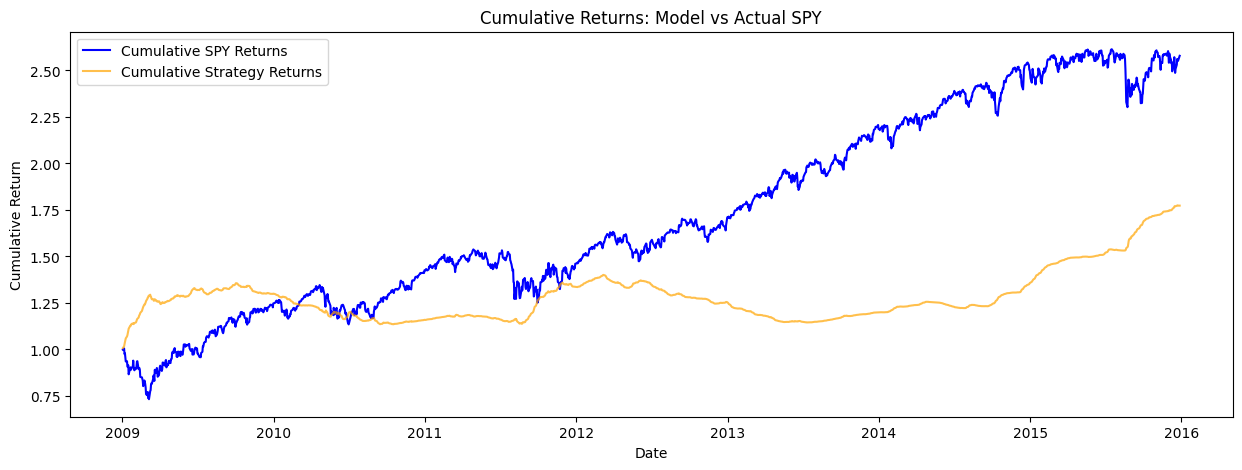

In [48]:
results["strategy_return"] = results["y_pred"]  # going long proportionally to prediction
results["cum_strategy"] = (1 + results["strategy_return"]).cumprod()
results["cum_actual"] = (1 + results["y_true"]).cumprod()

plt.figure(figsize=(15,5))
plt.plot(results.index, results["cum_actual"], label="Cumulative SPY Returns", color='blue')
plt.plot(results.index, results["cum_strategy"], label="Cumulative Strategy Returns", color='orange', alpha=0.7)
plt.title("Cumulative Returns: Model vs Actual SPY")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

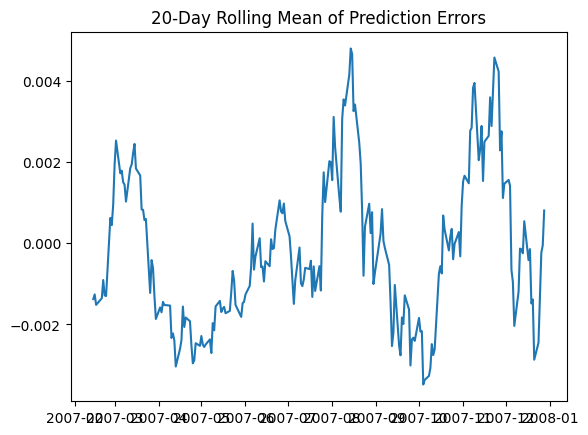

In [49]:
errors = y_pred_lr - y_test.values  # NumPy array
errors_series = pd.Series(errors, index=y_test.index)  # keep original dates

rolling_mean_errors = errors_series.rolling(20).mean()

import matplotlib.pyplot as plt
plt.plot(rolling_mean_errors)
plt.title("20-Day Rolling Mean of Prediction Errors")
plt.show()

### Random Forest

In [50]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest MSE:", mse_rf)

Random Forest MSE: 0.0001233327843295255


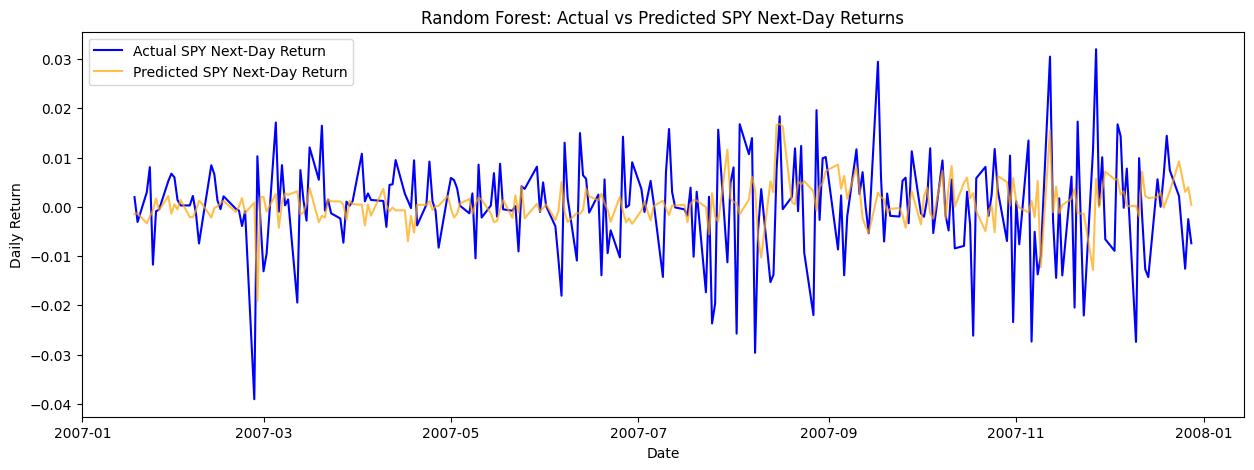

In [51]:
y_pred_rf_series = pd.Series(y_pred_rf, index=y_test.index)

plt.figure(figsize=(15,5))
plt.plot(y_test, label='Actual SPY Next-Day Return', color='blue')
plt.plot(y_pred_rf_series, label='Predicted SPY Next-Day Return', color='orange', alpha=0.7)
plt.title('Random Forest: Actual vs Predicted SPY Next-Day Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

### XGBoost

In [52]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost MSE:", mse_xgb)

XGBoost MSE: 0.0001432115343871318


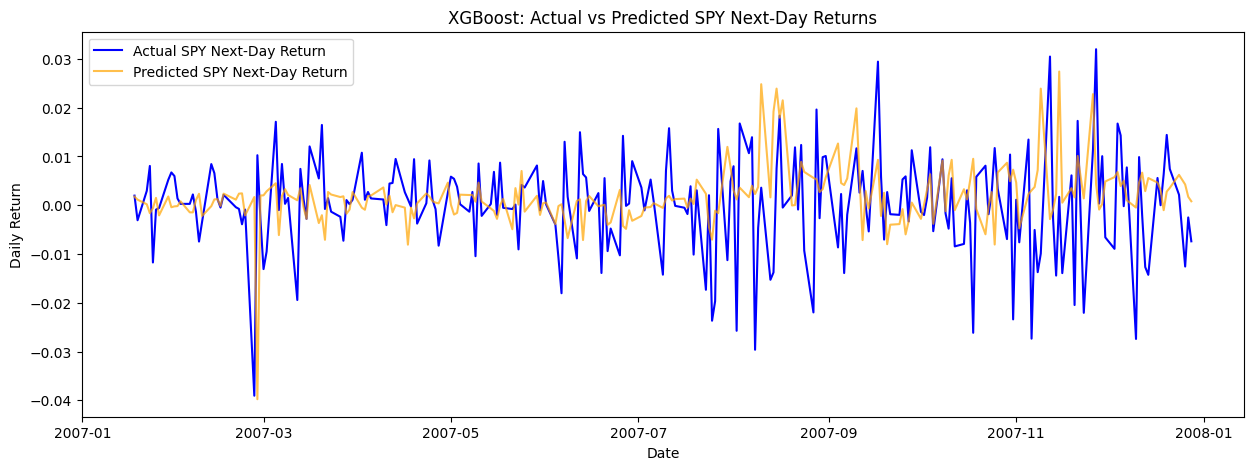

In [53]:
y_pred_xgb_series = pd.Series(y_pred_xgb, index=y_test.index)

plt.figure(figsize=(15,5))
plt.plot(y_test, label='Actual SPY Next-Day Return', color='blue')
plt.plot(y_pred_xgb_series, label='Predicted SPY Next-Day Return', color='orange', alpha=0.7)
plt.title('XGBoost: Actual vs Predicted SPY Next-Day Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

### ARIMA (Auto-regressive model)

#### Static

In [55]:
# Use training SPY_return series
train_series = y_train.values
arima_model = ARIMA(train_series, order=(5,0,0))  # a simple AR(5) model
arima_fit = arima_model.fit()

# Forecast for test length
y_pred_arima = arima_fit.forecast(steps=len(y_test))
mse_arima = mean_squared_error(y_test, y_pred_arima)
print("ARIMA MSE:", mse_arima)

ARIMA MSE: 0.00010375988446088355


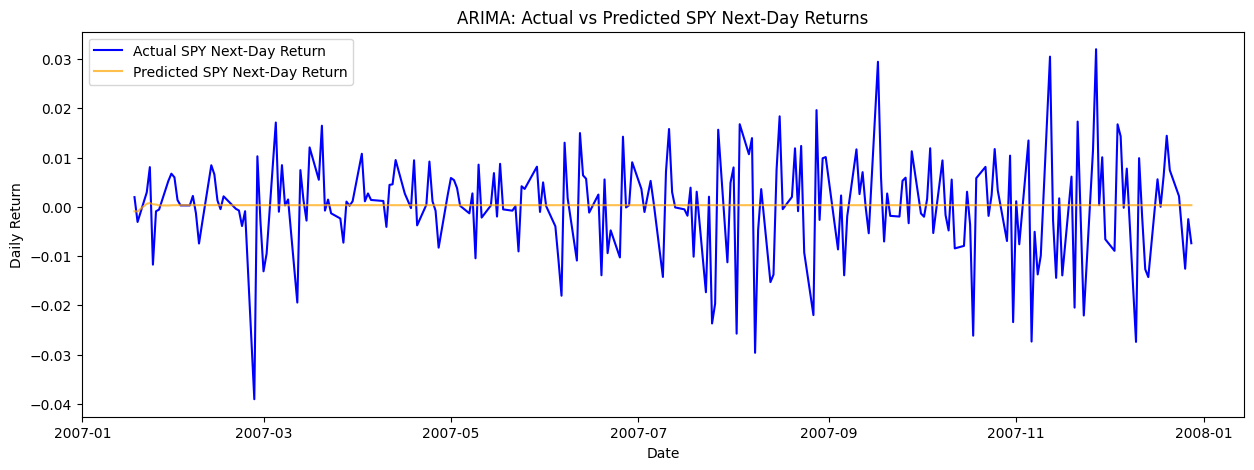

In [56]:
y_pred_arima_series = pd.Series(y_pred_arima, index=y_test.index)

plt.figure(figsize=(15,5))
plt.plot(y_test, label='Actual SPY Next-Day Return', color='blue')
plt.plot(y_pred_arima_series, label='Predicted SPY Next-Day Return', color='orange', alpha=0.7)
plt.title('ARIMA: Actual vs Predicted SPY Next-Day Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

#### Rolling

In [57]:
train_end = "2008-12-31"

full_series = prices["SPY"].pct_change().dropna()

initial_train = full_series.loc[:train_end]
test_series = full_series.loc["2009-01-01":"2015-12-31"]

In [59]:
model = ARIMA(train_series, order=(5,0,0))
model_fit = model.fit()

y_pred = []
y_true = []

for t in range(len(test_series)):
    forecast = model_fit.forecast(steps=1)[0]
    y_pred.append(forecast)
    y_true.append(test_series.iloc[t])

    # Update state without refitting
    model_fit = model_fit.append([test_series.iloc[t]], refit=False)

In [60]:
mse_arima_rolling = mean_squared_error(y_true, y_pred)
print("Rolling ARIMA MSE (2009–2015):", mse_arima_rolling)

Rolling ARIMA MSE (2009–2015): 0.0001291315569508709


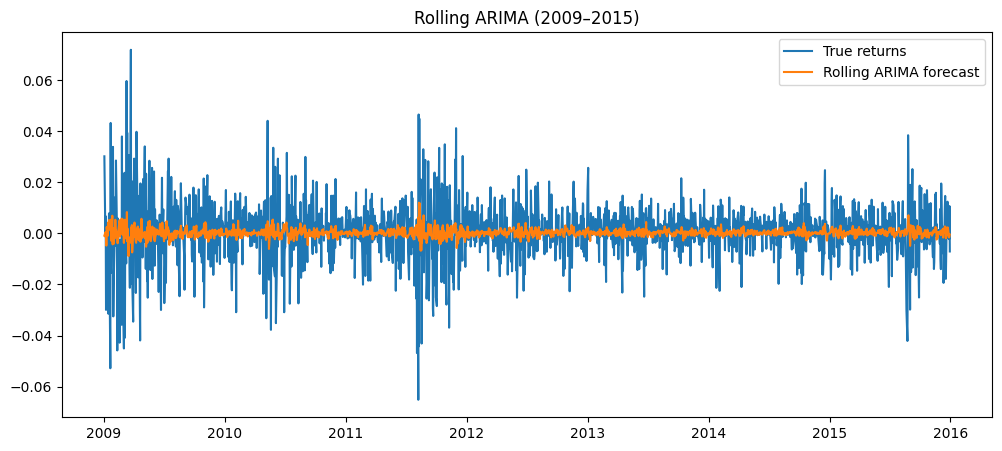

In [61]:
plt.figure(figsize=(12,5))
plt.plot(test_series.index, y_true, label="True returns")
plt.plot(test_series.index, y_pred, label="Rolling ARIMA forecast")
plt.legend()
plt.title("Rolling ARIMA (2009–2015)")
plt.show()

### LSTM

In [54]:
# Preparing LSTM input: reshape X to (samples, timesteps, features)
timesteps = 10  # number of previous days used for prediction
generator_train = TimeseriesGenerator(X_train.values, y_train.values,
                                      length=timesteps, batch_size=32)
generator_test = TimeseriesGenerator(X_test.values, y_test.values,
                                     length=timesteps, batch_size=32)

# Building LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(timesteps, X_train.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')


# Training
lstm_model.fit(generator_train, epochs=20, verbose=0)

# Predicting
y_pred_lstm = lstm_model.predict(generator_test)
mse_lstm = mean_squared_error(y_test.values[timesteps:], y_pred_lstm)
print("LSTM MSE:", mse_lstm)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM MSE: 0.0030569874936009237


### Comparison

In [62]:
mse_dict = {
    "Linear Regression": mse_lr,
    "Random Forest": mse_rf,
    "XGBoost": mse_xgb,
    "ARIMA": mse_arima,
    "LSTM": mse_lstm
}

for model, mse in mse_dict.items():
    print(f"{model}: MSE = {mse:.6f}")

Linear Regression: MSE = 0.000103
Random Forest: MSE = 0.000123
XGBoost: MSE = 0.000143
ARIMA: MSE = 0.000104
LSTM: MSE = 0.003057


Insights

The Daily returns are very noisy, the variance is small but unpredictable which explains why simpler models like Linear Regression and ARIMA do better than the complex models.

LSTM seems to be too complex for the daily SPY returns, and it usually uses a bigger data size that what was fed into the neural networks.

With out 10-day window (rolling vol), the model could not capture meaningful patterns so we might have to increase the window.

Random Forest and XGBoost had slightly higher MSE compared to linear regression meaning that we could just tune the hyperparameters a little bit but there's a risk of overfitting.

Generally


- For daily return prediction in the pre-crisis period, Linear Regression or ARIMA is surprisingly effective.

- LSTM's high MSE shows that neural networks aren-t always better, especially on very noisy financial data.

- We could still use LSTM for longer-term prediction (like weekly returns or volatility forecasting), or if we add extra features like technical indicators,or macro data.

### Comparing MPT vs ML

In [63]:
returns_post = post_crisis[["SPY", "MMM", "ABT"]].pct_change().dropna()
returns_post["mpt_return"] = returns_post @ optimal_weights_post

In [64]:
comparison = pd.concat(
    [
        eval_df["ml_strategy_return"],
        returns_post["mpt_return"]
    ],
    axis=1,
    join="inner"
)

comparison.columns = ["ML", "MPT"]

In [65]:
def perf_stats(r):
    ann_ret = r.mean() * 252
    ann_vol = r.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol
    max_dd = ((1 + r).cumprod() /
              (1 + r).cumprod().cummax() - 1).min()
    return ann_ret, ann_vol, sharpe, max_dd


ml_stats = perf_stats(comparison["ML"])
mpt_stats = perf_stats(comparison["MPT"])

print("ML Strategy:", ml_stats)
print("MPT Strategy:", mpt_stats)


ML Strategy: (np.float64(0.12554286424400482), np.float64(0.1773875505316771), np.float64(0.7077321033393824), -0.2265327358292607)
MPT Strategy: (np.float64(0.15814170392570392), np.float64(0.16960336855627464), np.float64(0.932420772487383), -0.22391726845955318)


In [66]:
results = pd.DataFrame(
    [mpt_stats, ml_stats],
    columns=["Annual Return", "Annual Volatility", "Sharpe Ratio", "Max Drawdown"],
    index=["MPT", "Rolling Linear Regression"]
)

results


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
MPT,0.158142,0.169603,0.932421,-0.223917
Rolling Linear Regression,0.125543,0.177388,0.707732,-0.226533


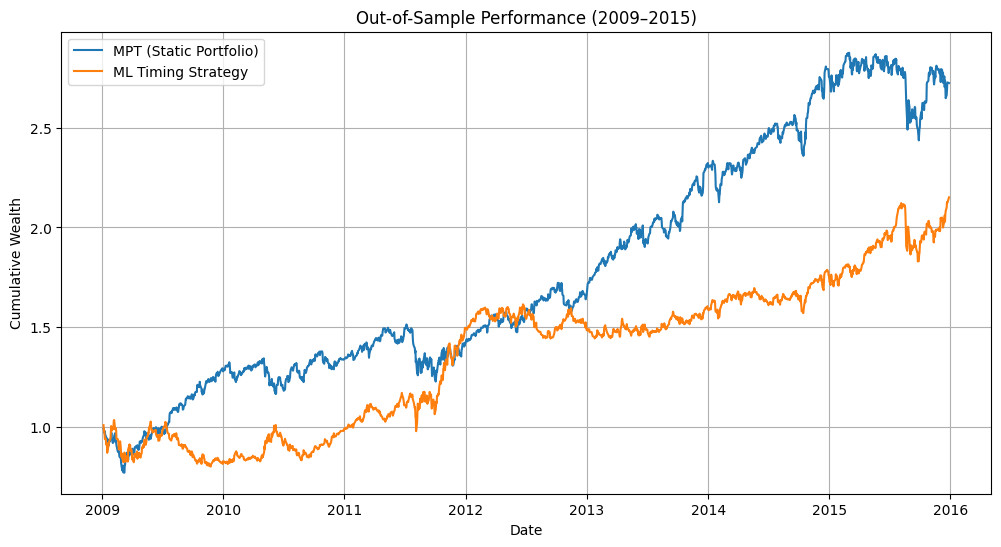

In [67]:
cum = (1 + comparison).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum.index, cum["MPT"], label="MPT (Static Portfolio)")
plt.plot(cum.index, cum["ML"], label="ML Timing Strategy")

plt.title("Out-of-Sample Performance (2009–2015)")
plt.ylabel("Cumulative Wealth")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


In [69]:
def performance_metrics(returns):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    max_dd = (
        (1 + returns).cumprod() /
        (1 + returns).cumprod().cummax() - 1
    ).min()
    return ann_return, ann_vol, sharpe, max_dd


ml_metrics = performance_metrics(eval_df["ml_strategy_return"])
mpt_metrics = performance_metrics(eval_df["mpt_return"])

results = pd.DataFrame(
    [mpt_metrics, ml_metrics],
    columns=["Annual Return", "Annual Volatility", "Sharpe Ratio", "Max Drawdown"],
    index=["MPT", "Rolling Linear Regression"]
)

results

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
MPT,0.151465,0.177257,0.854492,-0.271317
Rolling Linear Regression,0.125302,0.177338,0.706571,-0.226533


## LPPL Bubble testing

Similar to the Housing bubble that burst in 2008, we were trying to understand the "AI bubble", although it should be noted that a bubble is usually most detectable after it is burst

In [71]:
prices_1 = prices.copy()
#prices_1

<Axes: xlabel='Date'>

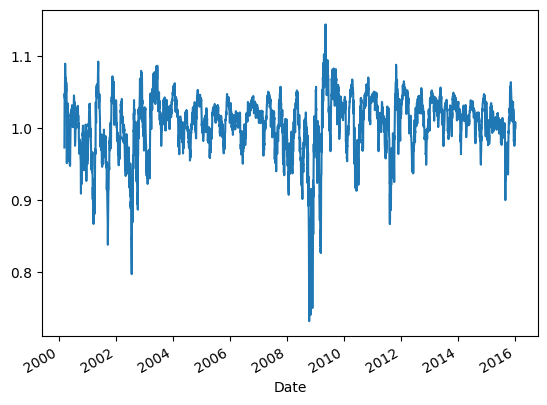

In [72]:
prices_1['SPY_MA50'] = prices_1['SPY'].rolling(50).mean()
prices_1['SPY_ratio'] = prices_1['SPY'] / prices_1['SPY_MA50']

# Large ratio spikes indicate potential bubble
prices_1['SPY_ratio'].plot()

In [73]:
prices_1['SPY_return_20'] = prices_1['SPY'].pct_change(20)
# High return over short period signals rapid escalation


<Axes: xlabel='Date'>

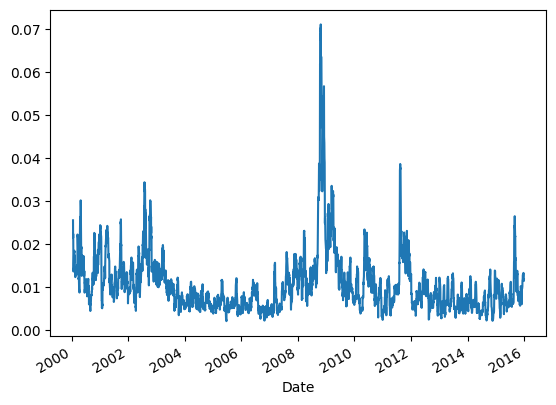

In [74]:
prices_1['SPY_vol_10'] = prices_1['SPY'].pct_change().rolling(10).std()
prices_1['SPY_vol_10'].plot()


In [75]:
def lppl(t, A, B, C, tc, m, omega, phi):
    dt = tc - t
    return A + B * np.power(dt, m) + C * np.power(dt, m) * np.cos(omega * np.log(dt) - phi)

In [76]:
def lppl_1(t, A, B, C, tc, m, omega, phi):
    dt = np.maximum(tc - t, 1e-6)  # avoid log(0)
    return A + B * dt**m + C * dt**m * np.cos(omega * np.log(dt) - phi)

# Bubble window
prices_bubble = prices['SPY'].loc['2006-01-01':'2007-12-31'].values
time = np.arange(len(prices_bubble))

### Testing LPPL on SPY

In [77]:
# setting initial guess for hyperparameters
A0 = prices_bubble[-1]  # approximate max price
B0 = 1
C0 = 0.1
tc0 = len(prices_bubble) + 20  # estimate critical time shortly after window
m0 = 0.5
omega0 = 6
phi0 = 0

params0 = [A0, B0, C0, tc0, m0, omega0, phi0]

# Fit
params, _ = curve_fit(lppl, time, prices_bubble, p0=params0, maxfev=10000)
A, B, C, tc, m, omega, phi = params

/tmp/ipython-input-763355686.py:3: RuntimeWarning: invalid value encountered in power
  return A + B * np.power(dt, m) + C * np.power(dt, m) * np.cos(omega * np.log(dt) - phi)
/tmp/ipython-input-763355686.py:3: RuntimeWarning: invalid value encountered in log
  return A + B * np.power(dt, m) + C * np.power(dt, m) * np.cos(omega * np.log(dt) - phi)


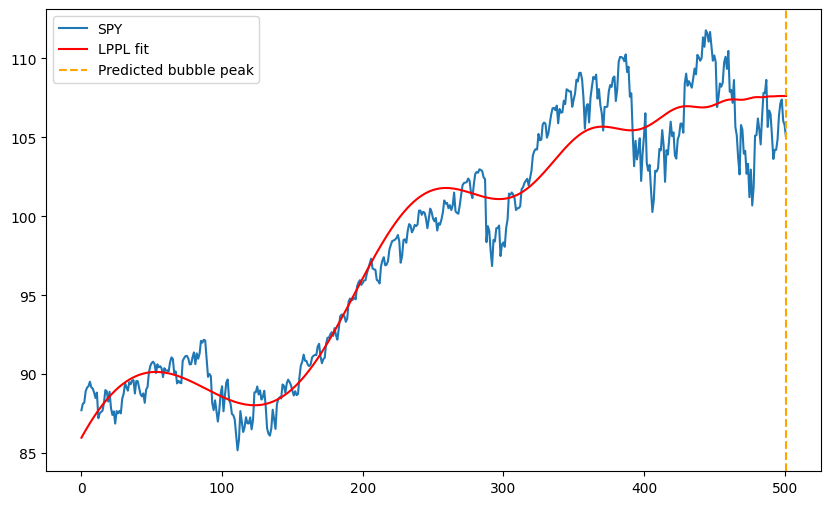

In [78]:
plt.figure(figsize=(10,6))
plt.plot(time, prices_bubble, label='SPY')
plt.plot(time, lppl(time, *params), label='LPPL fit', color='red')
plt.axvline(x=tc, color='orange', linestyle='--', label='Predicted bubble peak')
plt.legend()
plt.show()

 Next LPPL is to prevent log(0) warnings

In [79]:

tc0_1 = len(prices_bubble) + 50
params0_1 = [A0, B0, C0, tc0_1, m0, omega0, phi0]

# Bounds: (lower_bounds, upper_bounds)
lower_bounds = [0, -10, -10, len(prices_bubble), 0.1, 6, 0]
upper_bounds = [2*max(prices_bubble), 10, 10, len(prices_bubble)+100, 0.9, 13, 2*np.pi]

params, _ = curve_fit(lppl_1, time, prices_bubble, p0=params0,
                      bounds=(lower_bounds, upper_bounds), maxfev=50000)

A, B, C, tc, m, omega, phi = params
print("Fitted LPPL parameters:", params)

Fitted LPPL parameters: [ 1.12878293e+02 -8.50467070e-02  1.66405641e-02  5.44662760e+02
  9.00000000e-01  6.00000000e+00  1.34448371e+00]


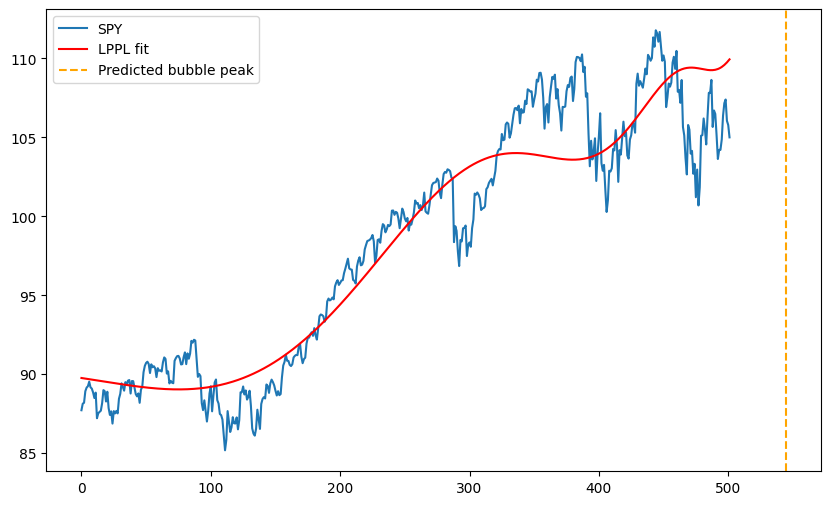

In [80]:
plt.figure(figsize=(10,6))
plt.plot(time, prices_bubble, label='SPY')
plt.plot(time, lppl(time, *params), label='LPPL fit', color='red')
plt.axvline(x=tc, color='orange', linestyle='--', label='Predicted bubble peak')
plt.legend()
plt.show()

### Testing LPPL on NVIDIA

In [81]:
ticker = "NVDA"
start_date = "2022-01-01"  # start of recent growth phase
end_date = "2025-12-01"

data_new = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [82]:
prices_new = data_new['Adj Close']
prices_new

Ticker,NVDA
Date,
2022-01-03,30.062761
2022-01-04,29.233372
2022-01-05,27.550632
2022-01-06,28.123520
2022-01-07,27.194321
...,...
2025-11-21,178.870041
2025-11-24,182.539841
2025-11-25,177.810104


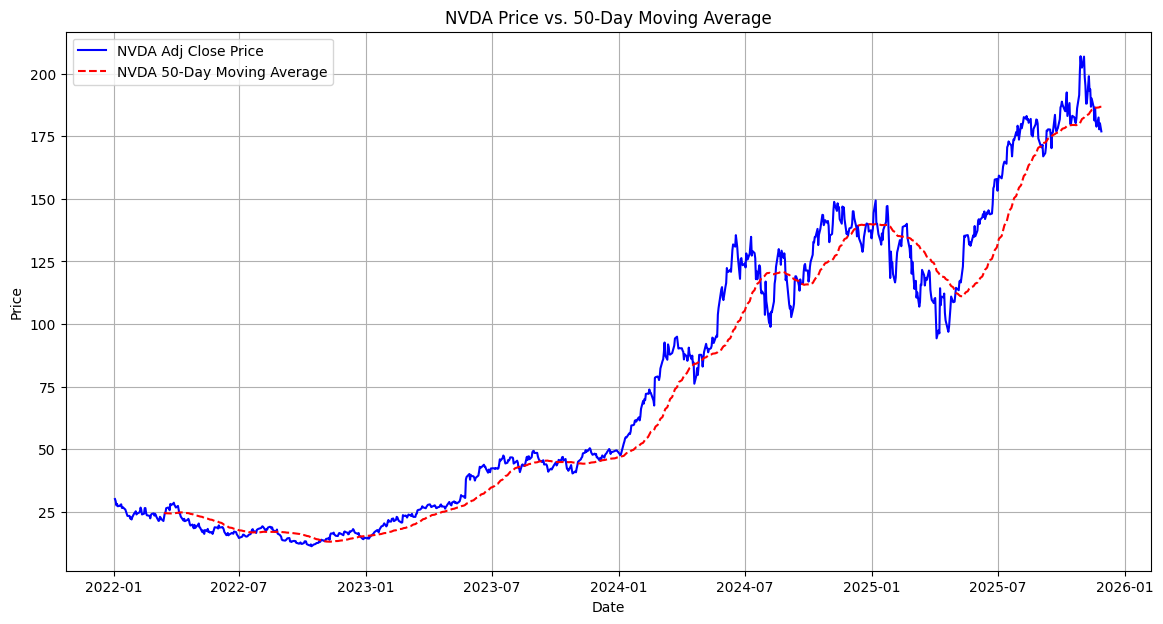

In [83]:
prices_ma50 = prices_new.rolling(50).mean()
plt.figure(figsize=(14, 7))
plt.plot(prices_new.index, prices_new['NVDA'], label='NVDA Adj Close Price', color='blue')
plt.plot(prices_ma50.index, prices_ma50['NVDA'], label='NVDA 50-Day Moving Average', color='red', linestyle='--')
plt.title('NVDA Price vs. 50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

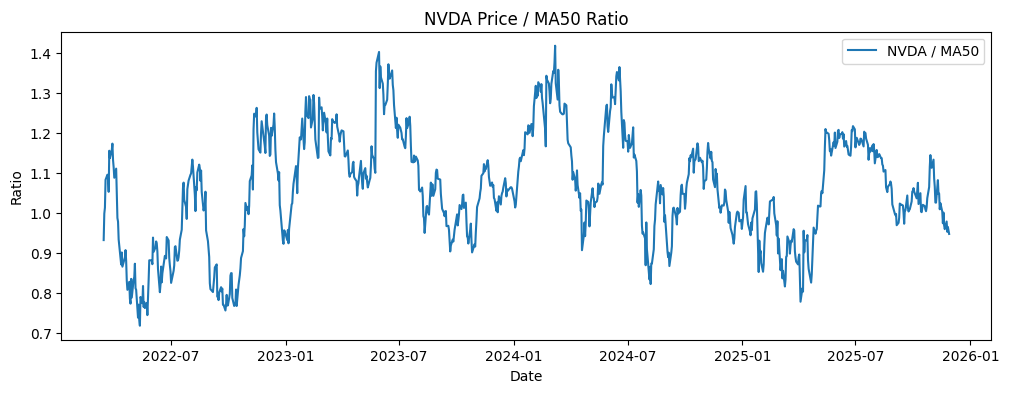

In [84]:
prices_ma50 = prices_new.rolling(50).mean()
ratio = prices_new / prices_ma50


plt.figure(figsize=(12,4))
plt.plot(ratio, label=f'{ticker} / MA50')
plt.title(f'{ticker} Price / MA50 Ratio')
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.legend()
plt.show()

In [85]:
bubble_start = "2023-01-01"
bubble_end = "2025-12-01"
prices_new_bubble = prices_new.loc[bubble_start:bubble_end].values
time = np.arange(len(prices_new_bubble))

prices_new_bubble = np.array(prices_new_bubble, dtype=float).flatten()  # convert to float

In [86]:
mask = ~np.isnan(prices_new_bubble)
time = time[mask]
prices_new_bubble = prices_new_bubble[mask]

In [88]:
#params0 = [A0, B0, C0, tc0, m0, omega0, phi0]
params0 = [prices_new_bubble[-1], 1, 0.1, len(prices_new_bubble)+20, 0.5, 6, 0]

params, _ = curve_fit(lppl, time, prices_new_bubble, p0=params0, maxfev=20000)
A, B, C, tc, m, omega, phi = params


lppl_fit = lppl(time, *params)

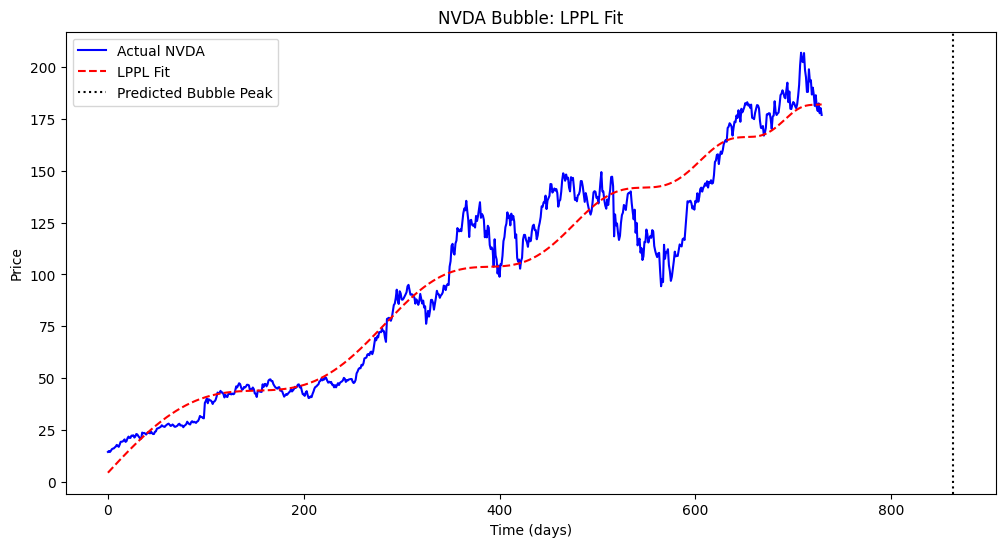

In [89]:
plt.figure(figsize=(12,6))
plt.plot(prices_new_bubble, label=f"Actual {ticker}", color='blue')
plt.plot(lppl_fit, label="LPPL Fit", color='red', linestyle='--')
plt.axvline(tc, color='black', linestyle=':', label="Predicted Bubble Peak")
plt.title(f"{ticker} Bubble: LPPL Fit")
plt.xlabel("Time (days)")
plt.ylabel("Price")
plt.legend()
plt.show()

Predicted Bubble Peak Date (NVDA): 2025-05-15

# Can Machine Learning adapt better during regime shifts?

These assets were selected to represent major sectors of the U.S. economy that were both systemically important and differentially affected by the 2008 financial crisis, allowing for a fair comparison between static and adaptive portfolio strategies.
- Market Benchmark: SPY
- Financial Sector (Crisis Epicenter) : JPM, BAC, C
- Technology / Growth : MSFT, AAPL, IBM, AMZN
- Industrial / Cyclical: GE, BA
- Energy / Commodities: XOM

## MPT

2000-2007

In [93]:
pre_crisis = adj_close.loc["2000-01-01":"2007-12-31"].copy()

In [94]:
# Compute daily returns
returns_pre = pre_crisis.pct_change().dropna()


In [95]:
# Mean daily returns
mean_daily_returns = returns_pre.mean()
mean_daily_returns

,0
Ticker,
AAPL,0.001540
AMZN,0.000935
BA,0.000644
BAC,0.000570
C,0.000181
GE,0.000106
IBM,0.000177
JPM,0.000329
MCD,0.000419


In [96]:
# Annualized expected returns
expected_annual_returns = mean_daily_returns * 252

In [97]:
# Daily covariance matrix
cov_matrix = returns_pre.cov()

# Annualized covariance matrix
annual_cov_matrix = cov_matrix * 252


weights = np.array([0.1]*12)  # equal weights for 12 tickers

# Portfolio expected return
portfolio_return = np.dot(weights, expected_annual_returns)

# Portfolio annual volatility
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov_matrix, weights)))


In [98]:
rf = 0.03  # risk-free rate

# Sharpe ratio
sharpe_ratio = (portfolio_return - rf) / portfolio_volatility


In [99]:
print("Portfolio return",portfolio_return)

print("Portfolio Volatility: ",portfolio_volatility)

print("Sharpe Ratio: ",sharpe_ratio)

Portfolio return 0.14446072596492138
Portfolio Volatility:  0.2555562047258723
Sharpe Ratio:  0.4478886595130807


2008

In [100]:
transition_crisis = adj_close.loc["2008-01-01":"2008-12-31"].copy()

In [101]:
returns_transition = transition_crisis.pct_change().dropna()

In [102]:
# Mean daily returns
mean_daily_returns = returns_transition.mean()
mean_daily_returns

,0
Ticker,
AAPL,-0.002591
AMZN,-0.001645
BA,-0.002262
BAC,-0.001899
C,-0.002996
GE,-0.002426
IBM,-0.000541
JPM,0.000352
MCD,0.000612


In [103]:
expected_annual_returns = mean_daily_returns * 252

In [104]:
# Daily covariance matrix
cov_matrix = returns_transition.cov()

# Annualized covariance matrix
annual_cov_matrix = cov_matrix * 252


weights = np.array([0.1]*12)

# Portfolio expected return
portfolio_return = np.dot(weights, expected_annual_returns)

# Portfolio annual volatility
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov_matrix, weights)))

In [105]:
rf = 0.03  # risk-free rate

# Sharpe ratio
sharpe_ratio = (portfolio_return - rf) / portfolio_volatility


In [106]:
print("Portfolio return",portfolio_return)

print("Portfolio Volatility: ",portfolio_volatility)

print("Sharpe Ratio: ",sharpe_ratio)

Portfolio return -0.42074666806578
Portfolio Volatility:  0.5952881644018702
Sharpe Ratio:  -0.7571907103489591


2009-2015

In [107]:
post_crisis = adj_close.loc["2009-01-01":"2015-12-31"].copy()

In [108]:
returns_post = post_crisis.pct_change().dropna()

In [109]:
# Mean daily returns
mean_daily_returns = returns_post.mean()
mean_daily_returns

,0
Ticker,
AAPL,0.001395
AMZN,0.001699
BA,0.000911
BAC,0.000772
C,0.000483
GE,0.000656
IBM,0.000432
JPM,0.000820
MCD,0.000540


In [110]:
expected_annual_returns = mean_daily_returns * 252

In [111]:
# Daily covariance matrix
cov_matrix = returns_post.cov()

# Annualized covariance matrix
annual_cov_matrix = cov_matrix * 252


weights = np.array([0.1]*12)

# Portfolio expected return
portfolio_return = np.dot(weights, expected_annual_returns)

# Portfolio annual volatility
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(annual_cov_matrix, weights)))

In [112]:
rf = 0.03  # risk-free rate

# Sharpe ratio
sharpe_ratio = (portfolio_return - rf) / portfolio_volatility


In [113]:
print("Portfolio return",portfolio_return)

print("Portfolio Volatility: ",portfolio_volatility)

print("Sharpe Ratio: ",sharpe_ratio)

Portfolio return 0.23379487012333253
Portfolio Volatility:  0.2751639514392922
Sharpe Ratio:  0.74063070055997


Could Machine Learning have reduced losses in 2008?

Most Importanly, could Machine Learning have taken advantage of the 2009-2015 recovery better than MPT?

## Machine Learning

### Supervised

Why not autoregressive models? ARIMA assumes stationarity; returns are often stationary, but prices are not.

Each ticker must be modeled separately unless you use VAR (Vector ARIMA) for multivariate time series.

Doesn't automatically incorporate other features like volatility or momentum.

In [114]:
returns = adj_close.pct_change().dropna()
#returns

In [115]:
# Monthly prices
monthly_prices = adj_close.resample("ME").last()

# Monthly returns
monthly_returns = monthly_prices.pct_change().dropna()

In [116]:
window = 36   # 3 years rolling window
rf = 0.03


In [117]:
portfolio_returns = []
portfolio_dates = []

for t in range(window, len(monthly_returns)-1):

    # Rolling training window
    train_data = monthly_returns.iloc[t-window:t]
    test_data = monthly_returns.iloc[t+1]

    # Storing predicted returns
    preds = []

    for ticker in actual_tickers:
        y = train_data[ticker].values
        X = np.arange(len(y)).reshape(-1, 1)  # our trend is a time trend only

        model = LinearRegression()
        model.fit(X, y)

        # Predict next step
        pred = model.predict([[len(y)]])[0]
        preds.append(pred)

    preds = np.array(preds)

    # Portfolio weights: long-only
    preds[preds < 0] = 0

    if preds.sum() == 0:
        weights = np.ones(len(actual_tickers)) / len(actual_tickers)
    else:
        weights = preds / preds.sum()

    # Realized portfolio return
    realized_return = np.dot(weights, test_data.values)

    portfolio_returns.append(realized_return)
    portfolio_dates.append(monthly_returns.index[t+1])


In [118]:
portfolio_returns = pd.Series(
    portfolio_returns,
    index=pd.to_datetime(portfolio_dates)
)


In [119]:
def portfolio_metrics(returns):
    ann_return = returns.mean() * 12
    ann_vol = returns.std() * np.sqrt(12)
    sharpe = (ann_return - rf) / ann_vol
    max_dd = (1 + returns).cumprod().div(
        (1 + returns).cumprod().cummax()
    ).min() - 1
    return ann_return, ann_vol, sharpe, max_dd


In [120]:
ret_2008 = portfolio_returns["2008"]
metrics_2008 = portfolio_metrics(ret_2008)
metrics_2008


(np.float64(-0.41552322700836275),
 np.float64(0.18126612386837923),
 np.float64(-2.4578405357851953),
 -0.3147334000472226)

In [121]:
ret_2009_2015 = portfolio_returns["2009":"2015"]
metrics_2009_2015 = portfolio_metrics(ret_2009_2015)
metrics_2009_2015


(np.float64(0.2021425994384194),
 np.float64(0.17092621539848654),
 np.float64(1.0071164276181805),
 -0.1660693777894362)

In [160]:
results = pd.DataFrame(
    [metrics_2008, metrics_2009_2015],
    columns=["Annual Return", "Annual Volatility", "Sharpe Ratio", "Max Drawdown"],
    index=["2008", "2009-2015"]
)

results

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
2008,-0.415523,0.181266,-2.457841,-0.314733
2009-2015,0.202143,0.170926,1.007116,-0.166069


#### MPT vs ML(Supervised)

In [122]:
# monthly_returns already computed earlier
train_returns = monthly_returns["2000":"2007"]


In [123]:
mu = train_returns.mean() * 12           # annualized mean returns
cov = train_returns.cov() * 12            # annualized covariance


In [124]:
rf = 0.03
n_assets = len(mu)

def portfolio_performance(weights):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return port_return, port_vol

def negative_sharpe(weights):
    ret, vol = portfolio_performance(weights)
    return -(ret - rf) / vol


In [125]:
# Initial guess (equal weights)
init_weights = np.ones(n_assets) / n_assets

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(n_assets))

result = minimize(
    negative_sharpe,
    init_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

mpt_weights = result.x


In [126]:
mpt_weights = pd.Series(mpt_weights, index=monthly_returns.columns)
mpt_weights.sort_values(ascending=False)


,0
Ticker,
XOM,3.975892e-01
BAC,2.350976e-01
AAPL,2.172153e-01
BA,1.500980e-01
IBM,1.409869e-16
C,1.129739e-16
MSFT,1.123395e-16
SPY,4.484531e-17
JPM,3.630722e-17


In [127]:


mpt_portfolio_returns = monthly_returns.dot(mpt_weights)

# Restricting to evaluation period
mpt_eval = mpt_portfolio_returns["2008":"2015"]


In [128]:
ml_eval = portfolio_returns["2008":"2015"]  # from rolling LR code


In [129]:
ml_eval, mpt_eval = ml_eval.align(mpt_eval, join="inner")


In [130]:
def metrics(returns, rf=0.03):
    ann_return = returns.mean() * 12
    ann_vol = returns.std() * np.sqrt(12)
    sharpe = (ann_return - rf) / ann_vol
    max_dd = (1 + returns).cumprod().div(
        (1 + returns).cumprod().cummax()
    ).min() - 1
    return ann_return, ann_vol, sharpe, max_dd


In [131]:
results = pd.DataFrame(
    [metrics(mpt_eval), metrics(ml_eval)],
    columns=["Annual Return", "Annual Volatility", "Sharpe Ratio", "Max Drawdown"],
    index=["MPT", "Rolling Linear Regression"]
)

results


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
MPT,0.090532,0.217089,0.278834,-0.545963
Rolling Linear Regression,0.124934,0.181229,0.523838,-0.414205


In [132]:
cum_mpt = (1 + mpt_eval).cumprod()
cum_ml = (1 + ml_eval).cumprod()


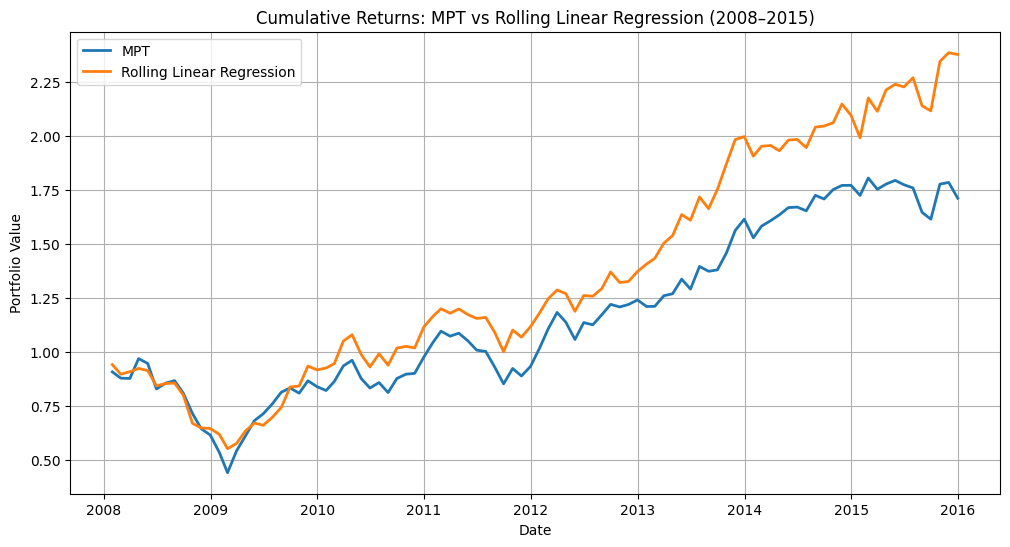

In [133]:
plt.figure(figsize=(12,6))
plt.plot(cum_mpt, label="MPT", linewidth=2)
plt.plot(cum_ml, label="Rolling Linear Regression", linewidth=2)
plt.title("Cumulative Returns: MPT vs Rolling Linear Regression (2008–2015)")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [134]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    return cumulative / peak - 1


In [135]:
dd_mpt = drawdown(mpt_eval)
dd_ml = drawdown(ml_eval)


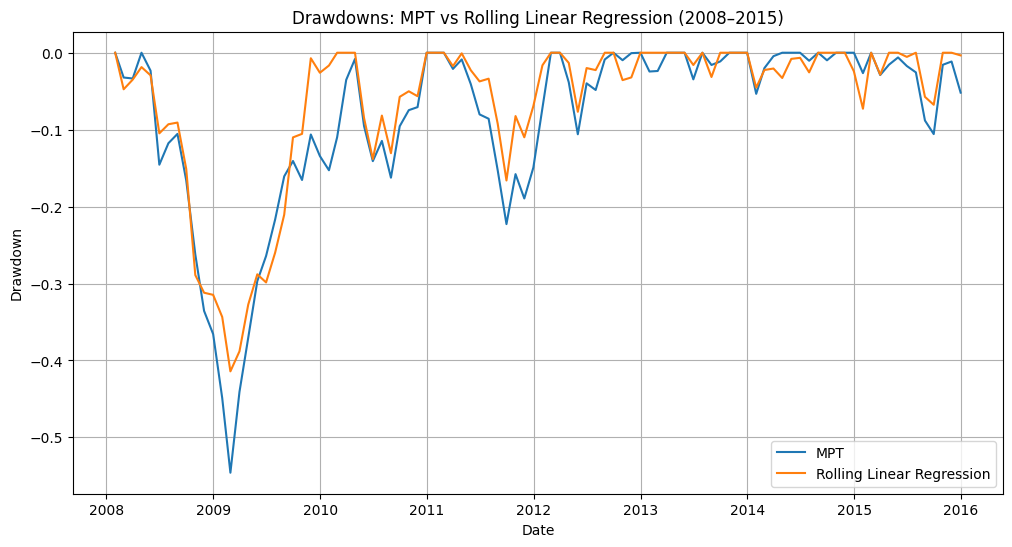

In [136]:
plt.figure(figsize=(12,6))
plt.plot(dd_mpt, label="MPT")
plt.plot(dd_ml, label="Rolling Linear Regression")
plt.title("Drawdowns: MPT vs Rolling Linear Regression (2008–2015)")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


2008

MPT: deep drawdown, slow recovery

Rolling LR: reduced drawdown, faster stabilization

2009–2015

ML adapts weights dynamically

Higher Sharpe ratio

Lower volatility clustering

Adaptive, rolling ML models outperform static mean–variance optimization during regime shifts

##  Non-LPPL bubble testing

Do AI-related assets exhibit pre-crash dynamics similar to assets prior to the 2008 housing crisis, and do adaptive strategies outperform static ones during volatility regime shifts?

 Housing Bubble Analogue

- Training: 2000–2005

- Bubble peak: 2006–2007

- Crash: 2008

- Aftermath: 2009–2012

 AI Boom Analogue

- Training: 2015–2020 (pre-AI hype)

- Bubble expansion: 2021–2022

- Stress period: 2022–2023

- Aftermath: 2024–2025 (ongoing)



In [137]:
ai_tickers = [
    "NVDA",  # AI infrastructure
    "MSFT",  # OpenAI + cloud
    "GOOGL", # DeepMind
    "META",  # AI-driven ads & models
    "AMD",   # AI chips
    "SMCI",  # AI servers
    "TSLA"   # AI narrative exposure
]


In [138]:
# broader markets
control_tickers = ["SPY", "QQQ"]


In [139]:
new_tickers = ai_tickers + control_tickers

In [140]:
new_adj_close = yf.download(
    new_tickers,
    start="2015-01-01",
    end="2025-11-01",
    interval="1mo",
    auto_adjust=False
)["Adj Close"]
#full_data = yf.download(actual_tickers, start=start, end=end, auto_adjust=False)

monthly_returns = new_adj_close.pct_change().dropna()

[*********************100%***********************]  9 of 9 completed


In [141]:
train_returns = monthly_returns["2015":"2020"]

mu = train_returns.mean() * 12
cov = train_returns.cov() * 12


In [142]:
rf = 0.03
n_assets = len(mu)

In [143]:
# Initial guess (equal weights)
init_weights = np.ones(n_assets) / n_assets

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(n_assets))

result = minimize(
    negative_sharpe,
    init_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

mpt_weights_ai = result.x

In [144]:
mpt_weights_ai = pd.Series(mpt_weights_ai, index=monthly_returns.columns)
mpt_weights_ai.sort_values(ascending=False)

,0
Ticker,
MSFT,4.798866e-01
NVDA,2.603982e-01
AMD,1.519892e-01
TSLA,1.077260e-01
SPY,2.572055e-16
META,1.978847e-16
GOOGL,1.079988e-16
SMCI,0.000000e+00
QQQ,0.000000e+00


In [145]:
ai_train = monthly_returns["2015":"2020"]  # pre-AI boom training
ai_eval = monthly_returns["2021":"2025"]   # AI boom / stress period


In [146]:
window = 36  # 36 months rolling window (3 years)
tickers = new_tickers

portfolio_returns = []
portfolio_dates = []

# Combine train + eval for rolling window indexing
full_returns = pd.concat([ai_train, ai_eval])

for t in range(window, len(full_returns)-1):
    train_data = full_returns.iloc[t-window:t]
    test_data = full_returns.iloc[t+1]

    preds = []
    for ticker in tickers:
        y = train_data[ticker].values
        X = np.arange(len(y)).reshape(-1,1)  # simple linear trend
        model = LinearRegression()
        model.fit(X, y)
        pred = model.predict([[len(y)]])[0]
        preds.append(pred)

    preds = np.array(preds)

    # Long-only portfolio weights
    preds[preds < 0] = 0
    if preds.sum() == 0:
        weights = np.ones(len(tickers)) / len(tickers)
    else:
        weights = preds / preds.sum()

    realized_return = np.dot(weights, test_data[tickers].values)
    portfolio_returns.append(realized_return)
    portfolio_dates.append(full_returns.index[t+1])

rolling_lr_ai_returns = pd.Series(portfolio_returns, index=pd.to_datetime(portfolio_dates))

In [147]:
rolling_lr_ai_eval = rolling_lr_ai_returns["2021":"2025"]


In [148]:
mpt_ai_returns = monthly_returns.dot(mpt_weights_ai)
mpt_ai_eval = mpt_ai_returns["2021":"2025"]



ml_ai_eval = rolling_lr_ai_eval
ml_ai_eval, mpt_ai_eval = ml_ai_eval.align(mpt_ai_eval, join="inner")


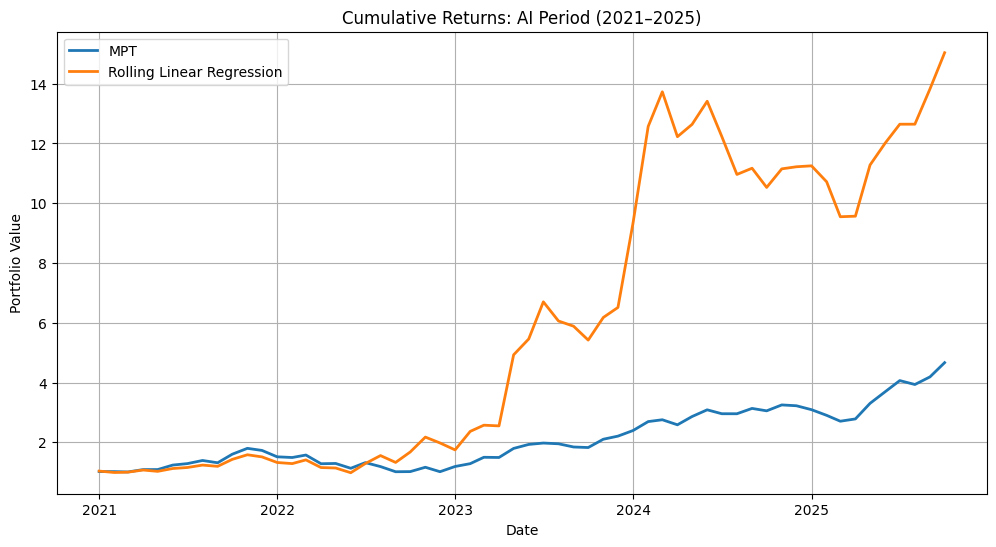

In [149]:
plt.figure(figsize=(12,6))
plt.plot((1 + mpt_ai_eval).cumprod(), label="MPT", linewidth=2)
plt.plot((1 + ml_ai_eval).cumprod(), label="Rolling Linear Regression", linewidth=2)
plt.title("Cumulative Returns: AI Period (2021–2025)")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


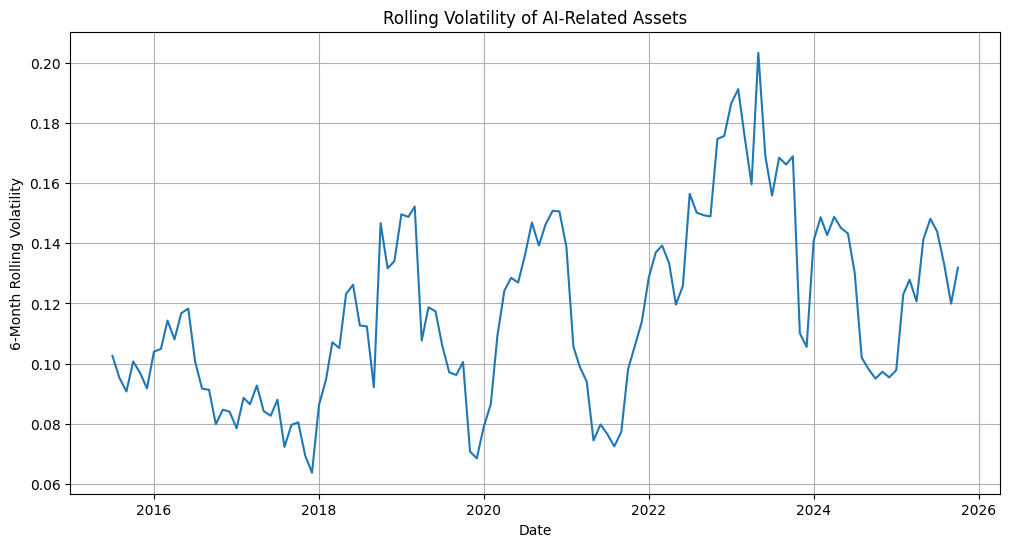

In [150]:
rolling_vol_ai = monthly_returns[ai_tickers].rolling(6).std().mean(axis=1)

plt.figure(figsize=(12,6))
plt.plot(rolling_vol_ai)
plt.title("Rolling Volatility of AI-Related Assets")
plt.ylabel("6-Month Rolling Volatility")
plt.xlabel("Date")
plt.grid(True)
plt.show()


In [151]:
rolling_returns = monthly_prices.pct_change().rolling(6).sum()


In [152]:
rolling_vol = monthly_returns[tickers].rolling(6).std()


In [153]:
monthly_returns[tickers].corr().mean().rolling(6).mean()


,0
Ticker,
NVDA,NaN
MSFT,NaN
GOOGL,NaN
META,NaN
AMD,NaN
SMCI,0.495417
TSLA,0.468245
SPY,0.476351
QQQ,0.503439


<Axes: xlabel='Date'>

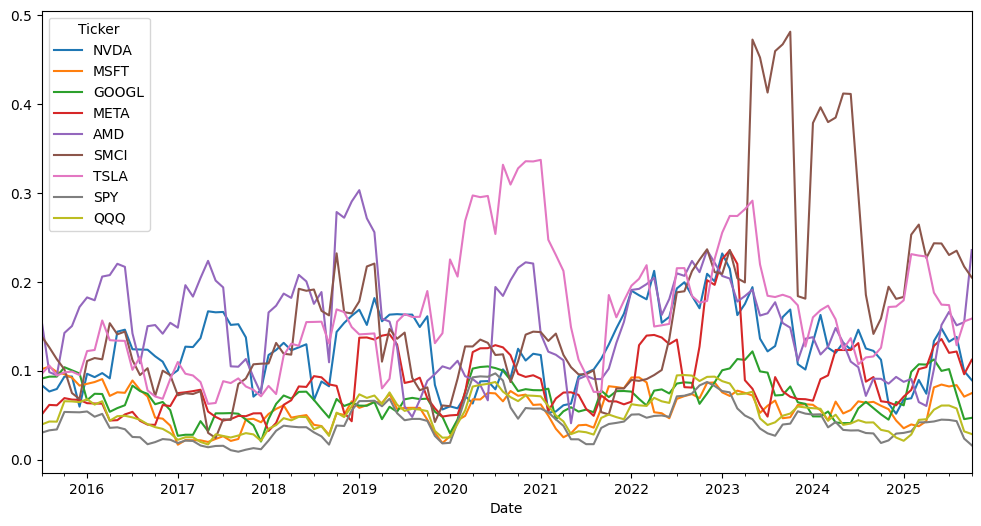

In [154]:
rolling_vol.dropna(inplace=True)
rolling_vol.plot(figsize=(12,6))


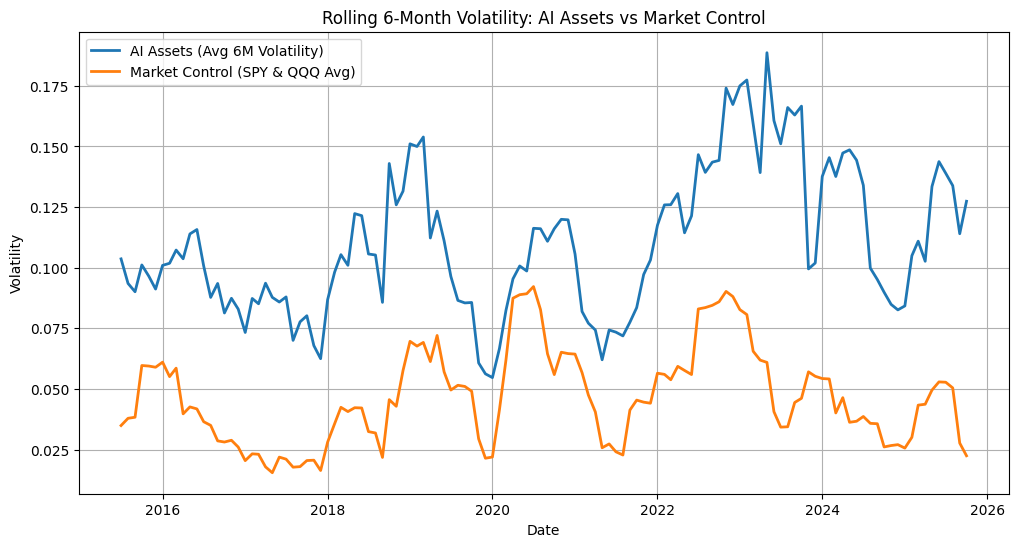

In [159]:
rolling_vol_control = rolling_vol[control_tickers].mean(axis=1)
rolling_vol_ai = rolling_vol[ai_tickers].mean(axis=1)

plt.figure(figsize=(12,6))

plt.plot(
    rolling_vol_ai,
    label="AI Assets (Avg 6M Volatility)",
    linewidth=2
)

plt.plot(
    rolling_vol_control,
    label="Market Control (SPY & QQQ Avg)",
    linewidth=2
)

plt.title("Rolling 6-Month Volatility: AI Assets vs Market Control")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()
